# Alarm

In [1]:
from IPython.display import Audio

# progressbar

In [2]:
import IPython
def progress(value, max=100):
    return IPython.display.HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Import modules

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.keras import layers,Model
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
plt.style.use('seaborn-white')
plt.rcParams.update({'font.size':15})
tf.test.gpu_device_name()

'/device:GPU:0'

# Loading DB

In [ ]:
import h5py

dataset="02"

name='v_induced1'
name2='v_induced3'

sensor1=pd.read_hdf('Dataset_{}/Dataset.h5'.format(dataset), key=name)  
sensor2=pd.read_hdf('Dataset_{}/Dataset.h5'.format(dataset), key=name2)  
labels=pd.read_hdf('Dataset_{}/Dataset.h5'.format(dataset), key='labels')  

# Compressing datsets .mat to .h5

## Compress Dataset_01

In [ ]:
import scipy.io 
mat=scipy.io.loadmat('Dataset_01/dataset_01.mat')
print(sorted(mat.keys()))
sensor1=pd.DataFrame(mat['v_induced1'])
sensor2=pd.DataFrame(mat['v_induced2'])
labels=pd.concat([pd.Series(np.squeeze(mat['x_str'])),pd.Series(np.squeeze(mat['y_str']))],axis=1)
labels.columns = ['X', 'Y']
labels.describe()
del mat
sensor1.to_hdf('Dataset_01/Dataset.h5', key=name, mode='w', complevel=9, complib='zlib')
sensor2.to_hdf('Dataset_01/Dataset.h5', key=name2, mode='a', complevel=9, complib='zlib')
labels.to_hdf('Dataset_01/Dataset.h5', key='labels', mode='a', complevel=9, complib='zlib')

## Compress Dataset_02

In [4]:
import scipy.io 
name='v_induced1'
name2='v_induced2'
name3='v_induced3'
name4='v_induced4'

mat=scipy.io.loadmat('Dataset_02/v_induced.mat')
print(sorted(mat.keys()))
sensor1=pd.DataFrame(mat[name])
sensor2=pd.DataFrame(mat[name2])
sensor3=pd.DataFrame(mat[name3])
sensor4=pd.DataFrame(mat[name4])
mat=scipy.io.loadmat('Dataset_02/str_point_fix.mat')
labels=pd.concat([pd.Series(np.squeeze(mat['x_str'])),pd.Series(np.squeeze(mat['y_str']))],axis=1)
labels.columns = ['X', 'Y']
labels.describe()
del mat
sensor1.to_hdf('Dataset_02/Dataset.h5', key=name, mode='w', complevel=9, complib='zlib')
sensor2.to_hdf('Dataset_02/Dataset.h5', key=name2, mode='a', complevel=9, complib='zlib')
sensor3.to_hdf('Dataset_02/Dataset.h5', key=name3, mode='a', complevel=9, complib='zlib')
sensor4.to_hdf('Dataset_02/Dataset.h5', key=name4, mode='a', complevel=9, complib='zlib')
labels.to_hdf('Dataset_02/Dataset.h5', key='labels', mode='a', complevel=9, complib='zlib')

['__globals__', '__header__', '__version__', 'v_induced1', 'v_induced2', 'v_induced3', 'v_induced4']


# Preprocess

## normalizeing

In [30]:
def normalize(dataframe):
    dataframe=dataframe/abs(dataframe).max()
    return dataframe

## resample

In [31]:
from scipy import signal
def simple(samplerate,x):
    temp=signal.resample_poly(x, samplerate,len(x))
    return temp  

## Choose DB

In [74]:
samplerate=2000

data={}
progressbar = display(progress(0, len(sensor1)), display_id=True)
for c,sample in enumerate(sensor1.iterrows()):
    sample=sample[1]
    #sample=normalize(sample)
    data[c]=simple(samplerate,sample)
    progressbar.update(progress(c+1, len(sensor1)))
    
#freqdata=pd.DataFrame.from_dict(freqdata,orient='index',columns=x)    
sensor1=pd.DataFrame.from_dict(data, orient='index')

data={}
progressbar = display(progress(0, len(sensor2)), display_id=True)
for c,sample in enumerate(sensor2.iterrows()):
    sample=sample[1]
    #sample=normalize(sample)
    data[c]=simple(samplerate,sample)
    progressbar.update(progress(c+1, len(sensor2)))

#freqdata=pd.DataFrame.from_dict(freqdata,orient='index',columns=x)    
sensor2=pd.DataFrame.from_dict(data, orient='index')

Audio('alarm.mp3',autoplay=True)
del data

# Plot for test

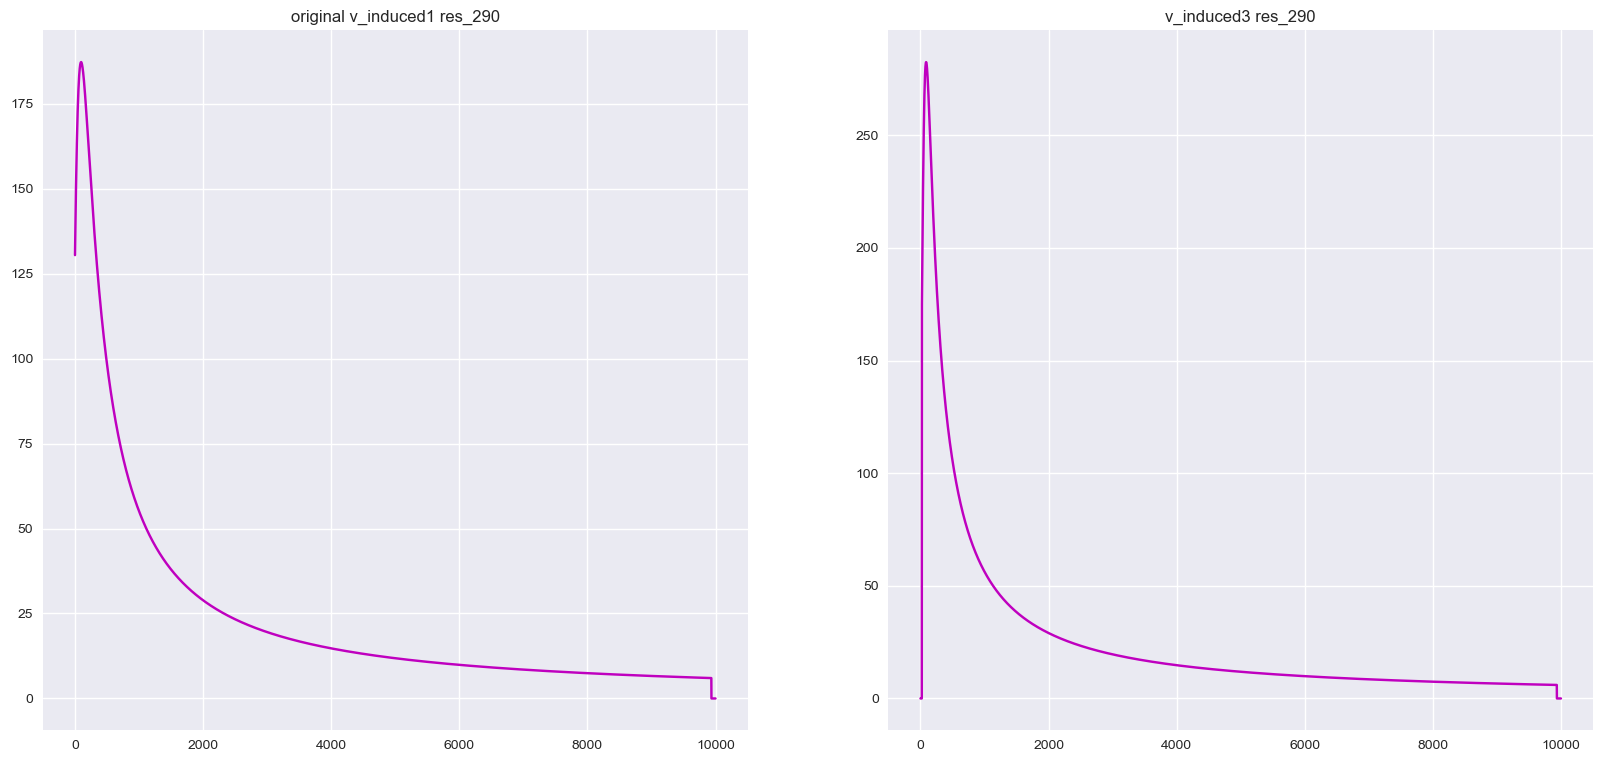

In [6]:
sample=290

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.title("original {} res_{}".format(name,sample))
plt.plot(sensor1.iloc[sample].tolist(),color = 'm')

plt.subplot(2,2,2)
plt.title("{} res_{}".format(name2,sample))
plt.plot(sensor2.iloc[sample].tolist(),color = 'm')

# 3d plot

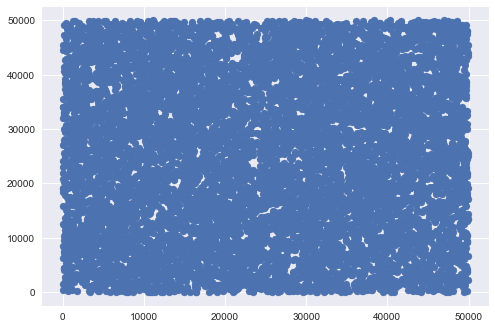

In [8]:
plt.scatter(labels['X'],labels['Y'])

## train 1D data

In [5]:
#sensor=sensor1-sensor2
sensor=np.concatenate((sensor1, sensor2), axis=1)
del sensor1
del sensor2
print(sensor.shape)
x_train, x_test, y_train, y_test = train_test_split(sensor, labels,random_state=46, test_size=0.2,shuffle=True)
del sensor
# x_train=x_train.iloc[:,:].values
# x_test=x_test.iloc[:,:].values

X_train = x_train.reshape(len(x_train), x_train.shape[1],1)
X_test = x_test.reshape(len(x_test), x_test.shape[1],1)

(10000, 20000)


# 1D model

In [96]:
import os
from pathlib import Path
logs = Path('logs')
if logs.exists():
  pass
else:
  os.mkdir(logs)
model_name_to_save='sensorlocation_case_study_sensor1_sensor3_config1'
model_name_to_save='logs/'+model_name_to_save
model_name_to_load=model_name_to_save

from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import GPUtil
tf.random.set_seed(46)
his_file = Path(model_name_to_save)
if his_file.exists():
    print('folder exist')
    his_file = Path("{}/history.csv".format(model_name_to_save))
    if his_file.exists():
      os.remove("{}/history.csv".format(model_name_to_save))
else:
    os.mkdir(model_name_to_save)
    
GPUtil.showUtilization(True)
# data = [x_test, y_test]
# testdataframe=pd.concat(data, axis=1)
# testdataframe.to_csv("{}/test_{}.csv".format(model_name_to_save,samplerate),index=False)
# data = [x_train, y_train]
# traindataframe=pd.concat(data, axis=1)
# traindataframe.to_csv("{}/train_{}.csv".format(model_name_to_save,samplerate),index=False)    
    
im_shape=(X_train.shape[1],1)

inputdata=tf.keras.Input(im_shape)


config1={'model':'snn','dense_layers':3,'dense_size1': 1024, 'dense_size2': 512, 'dense_size3': 256,'dense_size4': 0,'dense_size5': 0,"r3":0,"r4":0,"r5":0,"r6":0,"r7":0}
config2={'model':'cnn','dense_layers':3,'av1':30,'av2':0,'unit1': 128, 'unit2': 0, 'kernel1': 20, 'kernel2': 0,'drop1':0.1,'drop2':0, 'dense_size1': 64, 'dense_size2': 512, 'dense_size3': 512,"r1":0,"r2":0,"r3":0,"r4":0,"r5":0}
matin_config={'model':'snn','dense_layers':3,'dense_size1': 750, 'dense_size2': 512, 'dense_size3': 256,"r3":0,"r4":0,"r5":0}

def build_1D_model(config):
    if config['model']=='cnn':
        # x=layers.GaussianNoise(stddev=0.2)(inputdata) #layer 1
        if config['r1']==0:
          requlizer=None
        else:
          requlizer=l2(config['r1'])
        x=layers.Convolution1D(config['unit1'], (config['kernel1']), activation="relu",kernel_regularizer=requlizer)(inputdata)# 7 0.005
        x=layers.AveragePooling1D((config['av1']))(x)
        x=layers.Dropout(config['drop1'])(x) 

        # x=layers.Convolution1D(config['unit2'], (config['kernel2']),kernel_regularizer=l2(config['r2']), activation="relu" )(x) #layer 2 #256 3 0.1
        # x=layers.AveragePooling1D((config['av2']))(x)
        # x=layers.Dropout(config['drop2'])(x)

        x=layers.Flatten()(x) 
    else:
        x=layers.Flatten()(inputdata)

    if config['r3']==0:
      requlizer=None
    else:
      requlizer=l2(config['r3'])
    x=layers.Dense(config['dense_size1'],kernel_regularizer=requlizer, activation="relu")(x)
    if config['r4']==0:
      requlizer=None
    else:
      requlizer=l2(config['r4'])
    x=layers.Dense(config['dense_size2'],kernel_regularizer=requlizer, activation="relu")(x)
    if config['dense_layers']>=3:
        if config['r5']==0:
            requlizer=None
        else:
            requlizer=l2(config['r5'])
        x=layers.Dense(config['dense_size3'],kernel_regularizer=requlizer, activation="relu")(x)
    if config['dense_layers']>=4:
        if config['r6']==0:
            requlizer=None
        else:
            requlizer=l2(config['r6'])
        x=layers.Dense(config['dense_size4'],kernel_regularizer=requlizer, activation="relu")(x)
    if config['dense_layers']>=5:
        if config['r7']==0:
            requlizer=None
        else:
            requlizer=l2(config['r7'])
        x=layers.Dense(config['dense_size5'],kernel_regularizer=requlizer, activation="relu")(x)
    preoutput=layers.Dense(2)(x)

    model=Model(inputs=inputdata,outputs=preoutput,name=model_name_to_save)


    loss_fn=tf.keras.losses.MeanSquaredError(reduction="auto", name="mse")
    metric=[tf.keras.metrics.MeanSquaredError()]
    #loss_fn=pearson_loss() #custom

    model.compile(optimizer='nadam', loss=loss_fn ,metrics = metric)
    return model 

model=build_1D_model(config1)    
callbacks = [EarlyStopping(monitor='val_loss', patience=15),
             tf.keras.callbacks.TerminateOnNaN(),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=8,min_lr=0.00001,verbose=1),
             tf.keras.callbacks.CSVLogger("{}/history.csv".format(model_name_to_save), append=True),
             #ModelCheckpoint(filepath='{}/best_model.h5'.format(model_name_to_save), monitor='val_loss', save_best_only=True),
             ModelCheckpoint(filepath="{}/checkpoint/cp.ckpt".format(model_name_to_save),save_weights_only=True,save_best_only=True,monitor='val_loss',mode='min',verbose=1)]
GPUtil.showUtilization()
model.summary()

folder exist
| ID | Name                       | Serial | UUID                                     || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  0 | NVIDIA GeForce GTX 1660 Ti | [N/A]  | GPU-fe7330b7-0c1a-59de-c78c-cdc9191c8ca1 ||       45C |        0% |          75% ||       6144MB |      4600MB |      1378MB || Disabled     | Disabled       |
| ID | GPU | MEM |
------------------
|  0 |  1% | 75% |
Model: "logs/sensorlocation_case_study_sensor1_sensor3_config1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20000, 1)]        0         
                                                     

In [272]:
history=model.fit(X_train,y_train,epochs=200, callbacks=callbacks, batch_size=30,validation_data=(X_test,y_test))
Audio('alarm.mp3',autoplay=True)

Epoch 1/200
266/267 [============================>.] - ETA: 0s - loss: 164742176.0000 - mean_squared_error: 164742176.0000
Epoch 1: val_loss improved from inf to 116923528.00000, saving model to logs/sensorlocation_case_study_sensor3_sensor4_config1/checkpoint\cp.ckpt
267/267 [==============================] - 34s 125ms/step - loss: 164567632.0000 - mean_squared_error: 164567632.0000 - val_loss: 116923528.0000 - val_mean_squared_error: 116923528.0000 - lr: 0.0010
Epoch 2/200
265/267 [============================>.] - ETA: 0s - loss: 103243720.0000 - mean_squared_error: 103243720.0000
Epoch 2: val_loss did not improve from 116923528.00000
267/267 [==============================] - 5s 19ms/step - loss: 103712664.0000 - mean_squared_error: 103712664.0000 - val_loss: 122810344.0000 - val_mean_squared_error: 122810344.0000 - lr: 0.0010
Epoch 3/200
267/267 [==============================] - ETA: 0s - loss: 64704376.0000 - mean_squared_error: 64704376.0000
Epoch 3: val_loss improved from 1169

# K-FOLD cross validation

In [ ]:
from sklearn.model_selection import KFold
import math
# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)
fold_no = 1
acc_per_fold,loss_per_fold,corelations=[],[],[]
for train, test in kfold.split(inputs, targets):
    model=build_1D_model(config2)
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=10,
              epochs=100)
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])
    
    c,c2,index=0,0,0
    errors={}
    validation={}
    for i in model.predict(inputs[test]):
        x,y,z=i
        x2,y2,z2=targets[test][c2]
        validation[c]=[x,y,z,index,'predict']
        c+=1
        validation[c]=[x2,y2,z2,index,'real']
        c+=1
        c2+=1
        index+=1
        errors[c]=math.sqrt((1/3)*((x2-x)**2+(y2-y)**2+(z2-z)**2))

    validation=pd.DataFrame.from_dict(validation, orient='index',columns=['x','y','z','index','kind'])
    x=np.corrcoef(validation[validation['kind'] == 'predict']['x'],validation[validation['kind'] == 'real']['x'])[0][1]
    y=np.corrcoef(validation[validation['kind'] == 'predict']['y'],validation[validation['kind'] == 'real']['y'])[0][1]
    z=np.corrcoef(validation[validation['kind'] == 'predict']['z'],validation[validation['kind'] == 'real']['z'])[0][1]
    print("R:\n",x,y,z)
    corelations.append([x,y,z])
    # Increase fold number
    fold_no = fold_no + 1
    
Audio('alarm.mp3',autoplay=True)    

In [28]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - MSE: {acc_per_fold[i]}%')
    print(f'> R:{corelations[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> MSE: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> R: {np.mean(corelations)} (+- {np.std(corelations)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 11433.837890625 - MSE: 10042.265625%
> R:[0.9696407182394786, 0.48377705315889113, 0.4295973877885538]
------------------------------------------------------------------------
> Fold 2 - Loss: 10122.7470703125 - MSE: 8743.0810546875%
> R:[0.9659383385683495, 0.48556625156907557, 0.5668280135803098]
------------------------------------------------------------------------
> Fold 3 - Loss: 8266.4677734375 - MSE: 6864.9326171875%
> R:[0.9811652113278942, 0.6482988406204699, 0.5919294591649357]
------------------------------------------------------------------------
> Fold 4 - Loss: 10105.1962890625 - MSE: 8703.568359375%
> R:[0.9633396932024848, 0.513907571349001, 0.5479065479076851]
------------------------------------------------------------------------
> Fold 5 - Loss: 11287.8359375 - MSE: 9983.837890625%
> R:[0

# Tunning

In [66]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import RandomSearch,HyperParameters
from tensorflow.keras.regularizers import l2
im_shape=(X_train.shape[1],1)

# unit1,unit8,unit9,unit10,unit11=256,15,15,0.1,0.2
# unit2,unit3,unit4=128,128,128
unit5,unit6,unit7,unit11,unit13,unit15,unit17=0.0,0.0,0.0,0.0,0.0,0.0,0.0

def build_model(hp):
    dense_layer = hp.Int('dense_layer', min_value=2, max_value=4, step=1)
    unit2 = hp.Choice('dens1', values=[32,64,128,256,512,750])
    #unit5 = hp.Choice('dense1_regulator', values=[0.0,0.1,0.2,0.3,0.4,0.5])
    unit3 = hp.Choice('dens2', values=[32,64,128,256,512,750])
    #unit6= hp.Choice('dense2_regulator', values=[0.0,0.1,0.2,0.3,0.4,0.5])
    with hp.conditional_scope("dense_layer", [3,4,5,6]):
        if dense_layer>=3:
            unit4 = hp.Choice('dens3', values=[32,64,128,256,512,750])
            #unit7= hp.Choice('dense3_regulator', values=[0.0,0.1,0.2,0.3,0.4,0.5])
    with hp.conditional_scope("dense_layer", [4,5,6]):
        if dense_layer>=4:
            unit12 = hp.Choice('dens4', values=[32,64,128,256,512,750])
            #unit13= hp.Choice('dense4_regulator', values=[0.0,0.1,0.2,0.3,0.4,0.5])
    with hp.conditional_scope("dense_layer", [5,6]):
        if dense_layer>=5:
            unit14 = hp.Choice('dens5', values=[32,64,128,256,512,750])
            #unit15= hp.Choice('dense5_regulator', values=[0.0,0.1,0.2,0.3,0.4,0.5])
    with hp.conditional_scope("dense_layer", [6]):
        if dense_layer>=6:
            unit16 = hp.Choice('dens6', values=[32,64,128,256,512,750])
            #unit17= hp.Choice('dense6_regulator', values=[0.0,0.1,0.2,0.3,0.4,0.5])
            
    unit1 = hp.Choice('Conv_filters', values=[64,128,256])        
    unit8 = hp.Choice('Conv_kernel', values=[8,9,10,12,15,20,30])
    unit9 = hp.Choice('pol', values=[8,9,10,12,15,20,30])
    unit10 = hp.Choice('drop', values=[0.1,0.2,0.3])
    #unit11= hp.Choice('conv_regulator', values=[0.0,0.1,0.2,0.3,0.4,0.5])
    
    model = tf.keras.Sequential()
    model.add( layers.InputLayer(input_shape=im_shape))
        
    # model.add(
    #         layers.GaussianNoise(stddev=0.2)
    #       )

    model.add(
        layers.Convolution1D(unit1, (unit8), activation="relu",kernel_regularizer=l2(unit11), input_shape=im_shape )
    )
    model.add(
          layers.AveragePooling1D((unit9))
    )       
    model.add(
          layers.Dropout(unit10)
          )

#     model.add(
#         layers.Convolution1D(256, (10),kernel_regularizer=l2(0.3), activation="relu" )
#     )
#     model.add(
#           layers.AveragePooling1D((2))
#     )  
#     model.add(
#         layers.Dropout(0.2)
#     )
    
#     model.add(
#         layers.Convolution1D(unit1, (unit12),kernel_regularizer=l2(0.3), activation="relu" )
#     )
#     model.add(
#           layers.AveragePooling1D((unit13))
#     )  
#     model.add(
#         layers.Dropout(unit14)
#     )
    
    model.add(
      layers.Flatten(name="flatten")
    )
    model.add(
        layers.Dense(unit2,kernel_regularizer=l2(unit5), activation="relu",name="dense1")
    )
    model.add(
        layers.Dense(unit3,kernel_regularizer=l2(unit6), activation="relu",name="dense2")
    ) 
    with hp.conditional_scope("dense_layer", [3,4,5,6]):
        if dense_layer>=3:
            model.add(
                layers.Dense(unit4,kernel_regularizer=l2(unit7), activation="relu",name="dense3")
            )
    with hp.conditional_scope("dense_layer", [4,5,6]):
        if dense_layer>=4:
            model.add(
                layers.Dense(unit12,kernel_regularizer=l2(unit13), activation="relu",name="dense4")
            )
    with hp.conditional_scope("dense_layer", [5,6]):
        if dense_layer>=5:
            model.add(
                layers.Dense(unit14,kernel_regularizer=l2(unit15), activation="relu",name="dense5")
            )
    with hp.conditional_scope("dense_layer", [6]):
        if dense_layer>=6:
            model.add(
                layers.Dense(unit16,kernel_regularizer=l2(unit17), activation="relu",name="dense6")
            )  
    
    model.add(
        layers.Dense(2,name="output")
    )    
    model.compile(
        optimizer='nadam', loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mse") ,metrics = [tf.keras.metrics.MeanSquaredError()]
    )
    model.summary()
    return model

callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             tf.keras.callbacks.TerminateOnNaN(),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5,min_lr=0.001,verbose=1),
             #tf.keras.callbacks.CSVLogger("{}/history.csv".format(model_name_to_save), append=True),
            # ModelCheckpoint(filepath='{}/best_model.h5'.format(model_name_to_save), monitor='val_loss', save_best_only=True)
]
build_model(HyperParameters())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 19993, 64)         576       
                                                                 
 average_pooling1d_1 (Averag  (None, 2499, 64)         0         
 ePooling1D)                                                     
                                                                 
 dropout_1 (Dropout)         (None, 2499, 64)          0         
                                                                 
 flatten (Flatten)           (None, 159936)            0         
                                                                 
 dense1 (Dense)              (None, 32)                5117984   
                                                                 
 dense2 (Dense)              (None, 32)                1056      
                                                      

In [30]:
from keras_tuner import RandomSearch
trials=40
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=trials,
    seed=11,
    executions_per_trial=1,
    overwrite=False,
    directory="tuning",
    project_name="dense_tune_RandomSearch",
)

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense1 (Dense)              (None, 32)                640032    
                                                                 
 dense2 (Dense)              (None, 32)                1056      
                                                                 
 dense3 (Dense)              (None, 32)                1056      
                                                                 
 output (Dense)              (None, 2)                 66        
                                                                 
Total params: 642,210
Trainable params: 642,210
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_49"
________________________

In [67]:
from keras_tuner import BayesianOptimization
trials=80
tuner = BayesianOptimization(
    hypermodel=build_model,
    objective='val_mean_squared_error',
    max_trials=trials,
    seed=11,
    executions_per_trial=1,
    overwrite=False,
    directory="tuning",
    project_name="dense_tune_BayesianOptimization",
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 19993, 64)         576       
                                                                 
 average_pooling1d_2 (Averag  (None, 2499, 64)         0         
 ePooling1D)                                                     
                                                                 
 dropout_2 (Dropout)         (None, 2499, 64)          0         
                                                                 
 flatten (Flatten)           (None, 159936)            0         
                                                                 
 dense1 (Dense)              (None, 32)                5117984   
                                                                 
 dense2 (Dense)              (None, 32)                1056      
                                                      

In [68]:
tuner.search_space_summary()

Search space summary
Default search space size: 11
dense_layer (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
dens1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256, 512, 750], 'ordered': True}
dens2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256, 512, 750], 'ordered': True}
Conv_filters (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
Conv_kernel (Choice)
{'default': 8, 'conditions': [], 'values': [8, 9, 10, 12, 15, 20, 30], 'ordered': True}
pol (Choice)
{'default': 8, 'conditions': [], 'values': [8, 9, 10, 12, 15, 20, 30], 'ordered': True}
drop (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}
dens3 (Choice)
{'default': 32, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'dense_layer', 'values': [3, 4, 5, 6]}}], 'values': [32, 64, 128, 256, 512, 750], 'ordered': True}
dens4 (Choice)
{'default': 

In [71]:
while:
    try:
        tuner.search(X_train, y_train, epochs=20,batch_size=10,callbacks=callbacks, validation_data=(X_test, y_test))
        break
    except:
        pass
Audio('alarm.mp3',autoplay=True)


Search: Running Trial #20

Value             |Best Value So Far |Hyperparameter
3                 |3                 |dense_layer
32                |64                |dens1
256               |512               |dens2
64                |128               |Conv_filters
12                |9                 |Conv_kernel
8                 |12                |pol
0.1               |0.2               |drop
64                |256               |dens3

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19989, 64)         832       
                                                                 
 average_pooling1d (AverageP  (None, 2498, 64)         0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)           (None, 2498, 64)          0         
  

Traceback (most recent call last):
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "C:


Search: Running Trial #22

Value             |Best Value So Far |Hyperparameter
4                 |3                 |dense_layer
128               |64                |dens1
32                |512               |dens2
256               |128               |Conv_filters
30                |9                 |Conv_kernel
30                |12                |pol
0.1               |0.2               |drop
256               |256               |dens3
128               |None              |dens4

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19971, 256)        7936      
                                                                 
 average_pooling1d (AverageP  (None, 665, 256)         0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)      

Traceback (most recent call last):
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "C:


Search: Running Trial #25

Value             |Best Value So Far |Hyperparameter
3                 |3                 |dense_layer
32                |64                |dens1
128               |512               |dens2
64                |128               |Conv_filters
8                 |9                 |Conv_kernel
20                |12                |pol
0.1               |0.2               |drop
128               |256               |dens3

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19993, 64)         576       
                                                                 
 average_pooling1d (AverageP  (None, 999, 64)          0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)           (None, 999, 64)           0         
  

Traceback (most recent call last):
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "C:


Search: Running Trial #28

Value             |Best Value So Far |Hyperparameter
4                 |3                 |dense_layer
64                |64                |dens1
512               |512               |dens2
64                |128               |Conv_filters
8                 |9                 |Conv_kernel
15                |12                |pol
0.2               |0.2               |drop
128               |256               |dens3
750               |None              |dens4

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19993, 64)         576       
                                                                 
 average_pooling1d (AverageP  (None, 1332, 64)         0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)      

Traceback (most recent call last):
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "C:


Search: Running Trial #30

Value             |Best Value So Far |Hyperparameter
3                 |3                 |dense_layer
512               |64                |dens1
32                |512               |dens2
256               |128               |Conv_filters
15                |9                 |Conv_kernel
10                |12                |pol
0.3               |0.2               |drop
750               |256               |dens3

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19986, 256)        4096      
                                                                 
 average_pooling1d (AverageP  (None, 1998, 256)        0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)           (None, 1998, 256)         0         
  

Traceback (most recent call last):
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "C:


Search: Running Trial #31

Value             |Best Value So Far |Hyperparameter
2                 |3                 |dense_layer
750               |64                |dens1
128               |512               |dens2
256               |128               |Conv_filters
9                 |9                 |Conv_kernel
10                |12                |pol
0.2               |0.2               |drop



Traceback (most recent call last):
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\farzi\AppData\Roamin


Search: Running Trial #32

Value             |Best Value So Far |Hyperparameter
4                 |3                 |dense_layer
256               |64                |dens1
128               |512               |dens2
64                |128               |Conv_filters
12                |9                 |Conv_kernel
10                |12                |pol
0.2               |0.2               |drop
32                |256               |dens3
64                |None              |dens4

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19989, 64)         832       
                                                                 
 average_pooling1d (AverageP  (None, 1998, 64)         0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)      

Traceback (most recent call last):
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\farzi\AppData\Roamin


Search: Running Trial #35

Value             |Best Value So Far |Hyperparameter
3                 |3                 |dense_layer
750               |64                |dens1
750               |512               |dens2
128               |128               |Conv_filters
10                |20                |Conv_kernel
8                 |30                |pol
0.3               |0.1               |drop
512               |512               |dens3

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19991, 128)        1408      
                                                                 
 average_pooling1d (AverageP  (None, 2498, 128)        0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)           (None, 2498, 128)         0         
  

Traceback (most recent call last):
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "C:


Search: Running Trial #36

Value             |Best Value So Far |Hyperparameter
2                 |3                 |dense_layer
256               |64                |dens1
128               |512               |dens2
128               |128               |Conv_filters
30                |20                |Conv_kernel
20                |30                |pol
0.2               |0.1               |drop

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19971, 128)        3968      
                                                                 
 average_pooling1d (AverageP  (None, 998, 128)         0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)           (None, 998, 128)          0         
                                              

Traceback (most recent call last):
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "C:


Search: Running Trial #38

Value             |Best Value So Far |Hyperparameter
3                 |3                 |dense_layer
256               |64                |dens1
128               |512               |dens2
256               |128               |Conv_filters
8                 |20                |Conv_kernel
8                 |30                |pol
0.1               |0.1               |drop
128               |512               |dens3

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19993, 256)        2304      
                                                                 
 average_pooling1d (AverageP  (None, 2499, 256)        0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)           (None, 2499, 256)         0         
  

Traceback (most recent call last):
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "C:\Users\farzi\AppData\Roaming\Python\Python38\site-packages\keras_tuner\engine\hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "C:


Search: Running Trial #39

Value             |Best Value So Far |Hyperparameter
3                 |3                 |dense_layer
64                |64                |dens1
32                |512               |dens2
128               |128               |Conv_filters
20                |20                |Conv_kernel
15                |30                |pol
0.2               |0.1               |drop
64                |512               |dens3

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19981, 128)        2688      
                                                                 
 average_pooling1d (AverageP  (None, 1332, 128)        0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)           (None, 1332, 128)         0         
  

In [72]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'dense_layer': 3, 'dens1': 64, 'dens2': 512, 'Conv_filters': 128, 'Conv_kernel': 20, 'pol': 30, 'drop': 0.1, 'dens3': 512}


In [73]:
tuner.results_summary(trials)

Results summary
Results in tuning\dense_tune_BayesianOptimization
Showing 80 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 32 summary
Hyperparameters:
dense_layer: 3
dens1: 64
dens2: 512
Conv_filters: 128
Conv_kernel: 20
pol: 30
drop: 0.1
dens3: 512
Score: 1066064.25

Trial 03 summary
Hyperparameters:
dense_layer: 3
dens1: 64
dens2: 512
Conv_filters: 128
Conv_kernel: 9
pol: 12
drop: 0.2
dens3: 256
Score: 1286112.5

Trial 19 summary
Hyperparameters:
dense_layer: 3
dens1: 32
dens2: 256
Conv_filters: 64
Conv_kernel: 12
pol: 8
drop: 0.1
dens3: 64
Score: 1414283.75

Trial 14 summary
Hyperparameters:
dense_layer: 4
dens1: 64
dens2: 512
Conv_filters: 256
Conv_kernel: 12
pol: 8
drop: 0.2
dens3: 32
dens4: 750
Score: 1456472.75

Trial 07 summary
Hyperparameters:
dense_layer: 2
dens1: 32
dens2: 512
Conv_filters: 256
Conv_kernel: 30
pol: 10
drop: 0.1
Score: 1544617.0

Trial 27 summary
Hyperparameters:
dense_layer: 4
dens1: 64
dens2: 512
Conv_filters: 64
Conv_kernel: 

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
loss, accuracy = best_model.evaluate(X_test, y_test)

# save model architecture

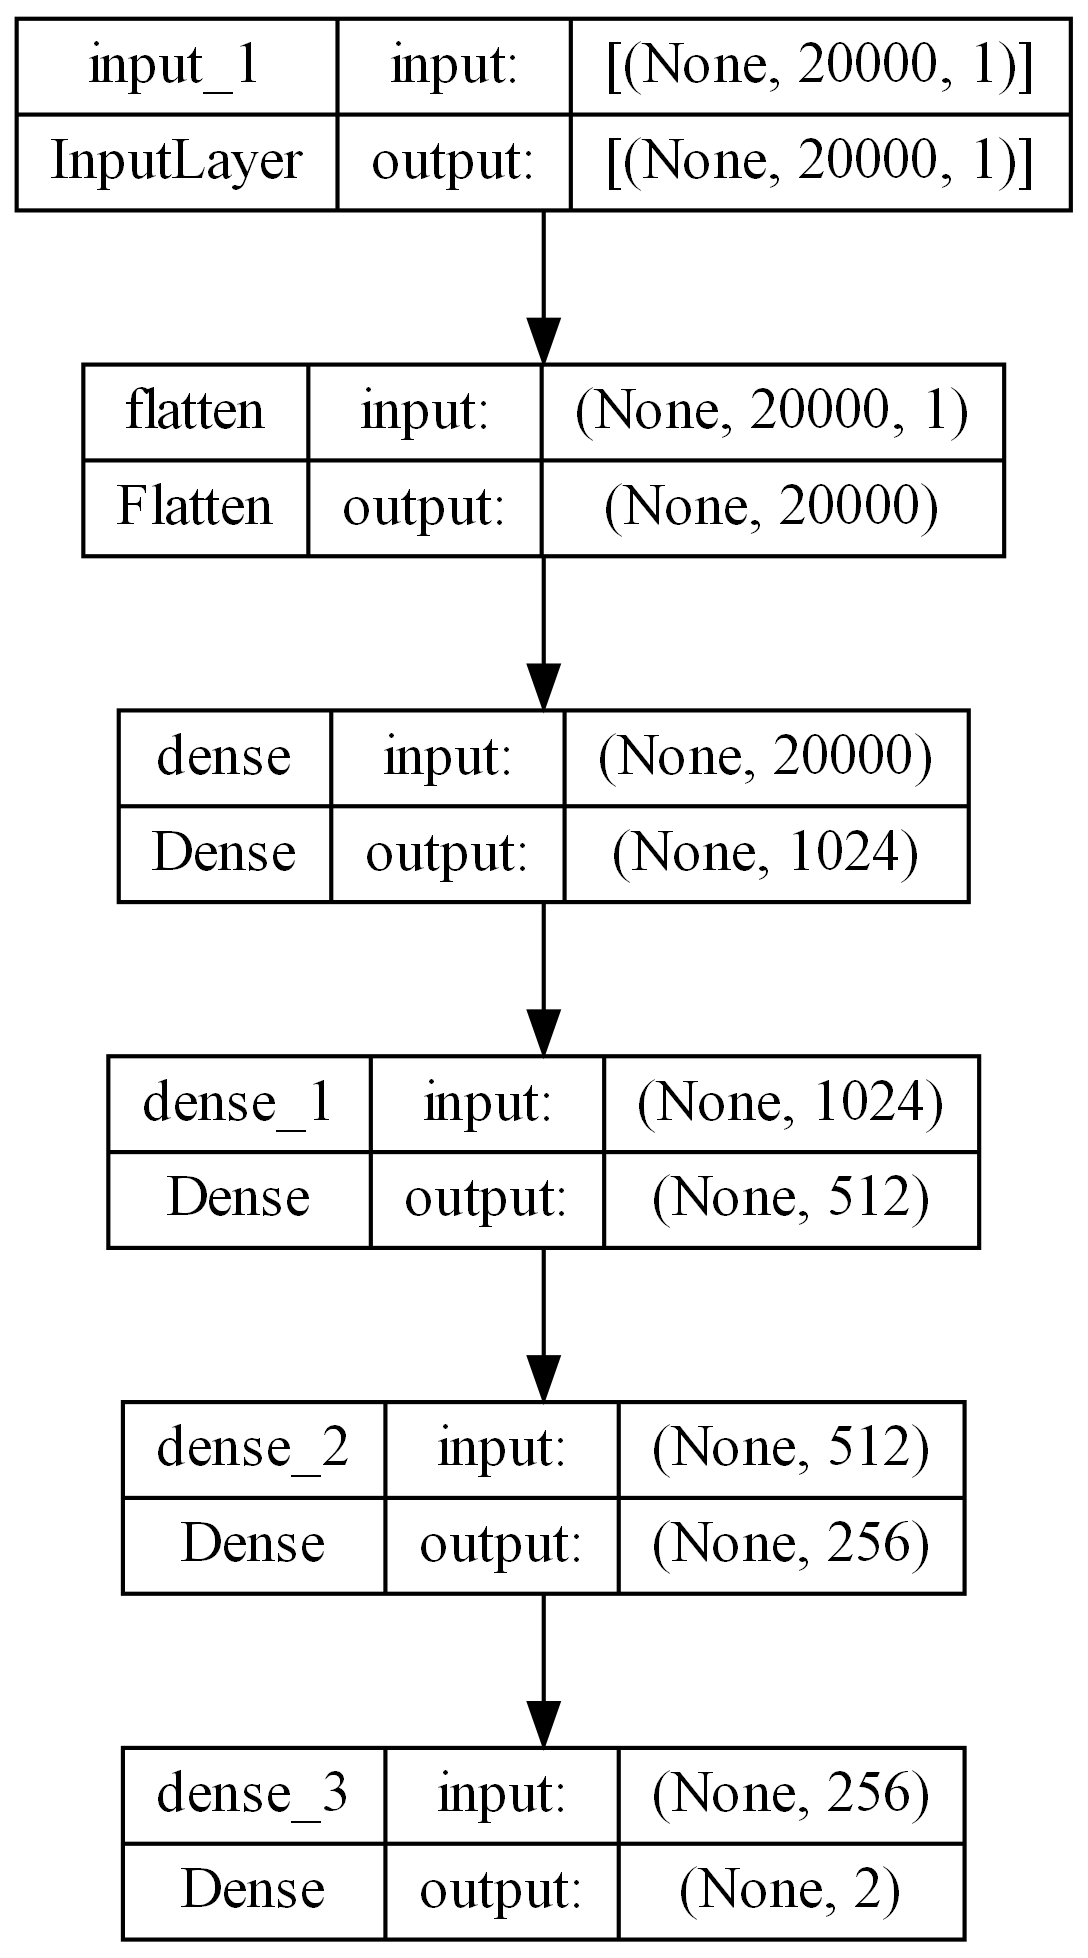

In [7]:
tf.keras.utils.plot_model(model,to_file="{}/architecture.png".format(model_name_to_save),show_layer_names=True,dpi=300,show_shapes=True,expand_nested=True)

# plot history

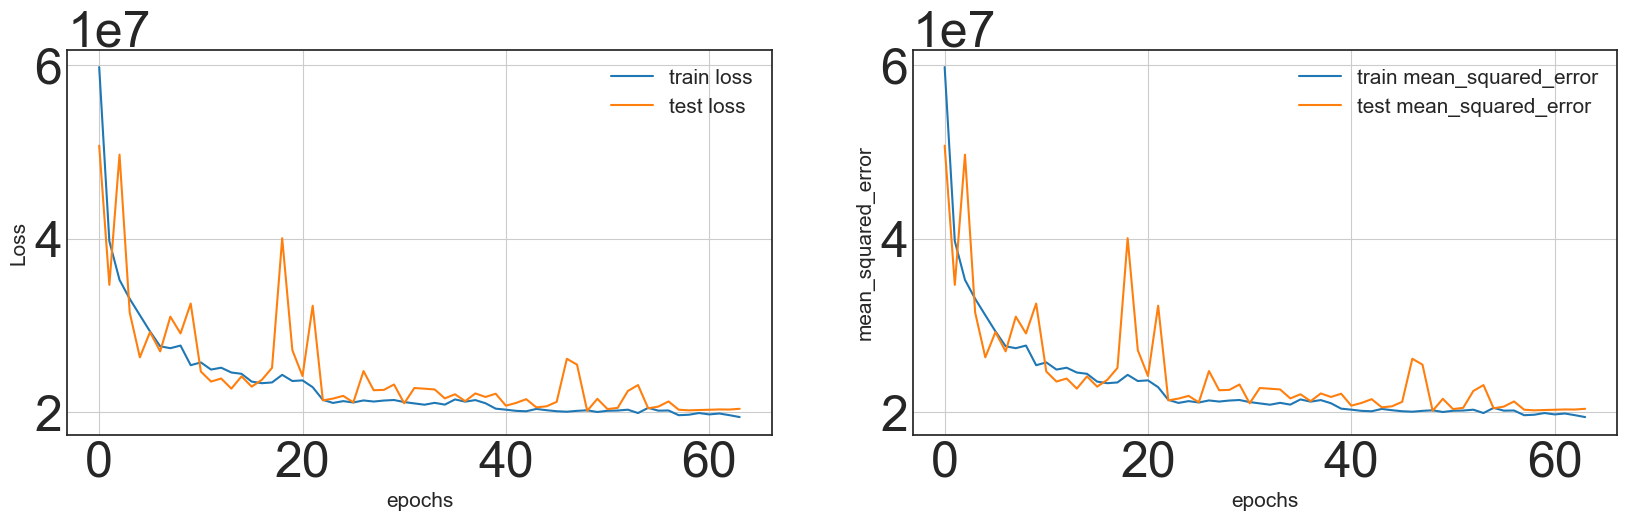

In [273]:
plt.figure(1,figsize=(20,5))
plt.subplot(1,2,1)
plt.xlabel("epochs")
plt.ylabel("Loss")
plotfrom=3

plt.plot(history.history['loss'][plotfrom:], label = 'train loss')
plt.plot(history.history['val_loss'][plotfrom:], label = 'test loss')
try:
    plt.plot(history.history['X_loss'][plotfrom:], label = 'X train loss')
    plt.plot(history.history['val_X_loss'][plotfrom:], label = 'X test loss')
    plt.plot(history.history['Y_loss'][plotfrom:], label = 'Y train loss')
    plt.plot(history.history['val_Y_loss'][plotfrom:], label = 'Y test loss')
    plt.plot(history.history['Z_loss'][plotfrom:], label = 'Z train loss')
    plt.plot(history.history['val_Z_loss'][plotfrom:], label = 'Z test loss')
except:
    pass
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("epochs")
try:
    plt.ylabel('mean_squared_error')
    plt.plot(history.history['X_mean_squared_error'][plotfrom:], label = 'X train mean_squared_error')
    plt.plot(history.history['val_X_mean_squared_error'][plotfrom:], label = 'X test mean_squared_error' )
    plt.plot(history.history['Y_mean_squared_error'][plotfrom:], label = 'Y train mean_squared_error')
    plt.plot(history.history['val_Y_mean_squared_error'][plotfrom:], label = 'Y test mean_squared_error' )
    plt.plot(history.history['Z_mean_squared_error'][plotfrom:], label = 'Z train mean_squared_error')
    plt.plot(history.history['val_Z_mean_squared_error'][plotfrom:], label = 'Z test mean_squared_error' )
except:
    plt.ylabel('mean_squared_error')
    plt.plot(history.history['mean_squared_error'][plotfrom:], label = 'train mean_squared_error')
    plt.plot(history.history['val_mean_squared_error'][plotfrom:], label = 'test mean_squared_error' )
plt.grid(True)
plt.legend()
plt.savefig('{}/graph.png'.format(model_name_to_save))

# save hyperparameters

In [274]:
model_config = model.get_config()['layers']
text=''
for layer in model_config:
    classname=layer['class_name']
    try:
        name=layer['name']
    except:
        name=layer['config']['name']
    config = layer['config']
    print('-'*20,'(',classname,'\t',name,')','-'*20)
    text+='-'*20+'('+classname+'\t'+name+')'+'-'*20+'\n'
    for key,value in config.items():    
        if value==None or key=='name' or key=='trainable' or key=='dtype':
            continue
        print(key,'\t',value)
        text+=key+'\t'+str(value)+'\n'
f=open('{}/hyperparameters.txt'.format(model_name_to_save),'w')  
f.write(text)
f.close()

-------------------- ( InputLayer 	 input_18 ) --------------------
batch_input_shape 	 (None, 20000, 1)
sparse 	 False
ragged 	 False
-------------------- ( Flatten 	 flatten_32 ) --------------------
data_format 	 channels_last
-------------------- ( Dense 	 dense_128 ) --------------------
units 	 1024
activation 	 relu
use_bias 	 True
kernel_initializer 	 {'class_name': 'GlorotUniform', 'config': {'seed': None}}
bias_initializer 	 {'class_name': 'Zeros', 'config': {}}
-------------------- ( Dense 	 dense_129 ) --------------------
units 	 512
activation 	 relu
use_bias 	 True
kernel_initializer 	 {'class_name': 'GlorotUniform', 'config': {'seed': None}}
bias_initializer 	 {'class_name': 'Zeros', 'config': {}}
-------------------- ( Dense 	 dense_130 ) --------------------
units 	 256
activation 	 relu
use_bias 	 True
kernel_initializer 	 {'class_name': 'GlorotUniform', 'config': {'seed': None}}
bias_initializer 	 {'class_name': 'Zeros', 'config': {}}
-------------------- ( Dense 	 

## Load Weights

In [97]:
model=build_1D_model(config1) 
model.load_weights("{}/checkpoint/cp.ckpt".format(model_name_to_save))
model.summary()

Model: "logs/sensorlocation_case_study_sensor1_sensor3_config1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20000, 1)]        0         
                                                                 
 flatten_5 (Flatten)         (None, 20000)             0         
                                                                 
 dense_20 (Dense)            (None, 1024)              20481024  
                                                                 
 dense_21 (Dense)            (None, 512)               524800    
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 dense_23 (Dense)            (None, 2)                 514       
                                                                 
Total params

# evaluate on test data

In [276]:
# Evaluate the model on the test data using `evaluate`
with open('{}/evaluate.txt'.format(model_name_to_save),'w') as f:
    print("Evaluate on test data")
    f.write("Evaluate on test data\n")
    results = model.evaluate(X_test, y_test, batch_size=4,verbose=2)
    print("Test loss:", results[0])
    f.write("Test loss:{}\n".format(results[0]))
    print("Test mean_squared_error:", results[1])
    f.write("Test mean_squared_error:{}\n".format(results[1]))

Evaluate on test data
500/500 - 1s - loss: 20188232.0000 - mean_squared_error: 20188232.0000 - 906ms/epoch - 2ms/step
Test loss: 20188232.0
Test mean_squared_error: 20188232.0


## train history

In [26]:
import csv
import pathlib
from pprint import pprint
his=pd.read_csv('{}/history.csv'.format(model_name_to_load))
print("total epochs:",len(his['epoch']))
his

total epochs: 74


,epoch,loss,lr,mean_squared_error,val_loss,val_mean_squared_error
0,0,199250128.0,0.001,199239376.0,103758200.0,103744032.0
1,1,89718296.0,0.001,89703752.0,70853168.0,70838272.0
2,2,71879784.0,0.001,71864392.0,61144828.0,61128968.0
3,3,64161152.0,0.001,64145024.0,59409204.0,59392832.0
4,4,60961772.0,0.001,60945008.0,56384576.0,56367336.0
...,...,...,...,...,...,...
69,69,42511684.0,0.001,42472656.0,41272856.0,41233712.0
70,70,42349388.0,0.001,42310252.0,40443864.0,40404708.0
71,71,42443072.0,0.001,42403852.0,40514680.0,40475320.0
72,72,42347284.0,0.001,42308028.0,39503184.0,39463772.0


### plot trained model history

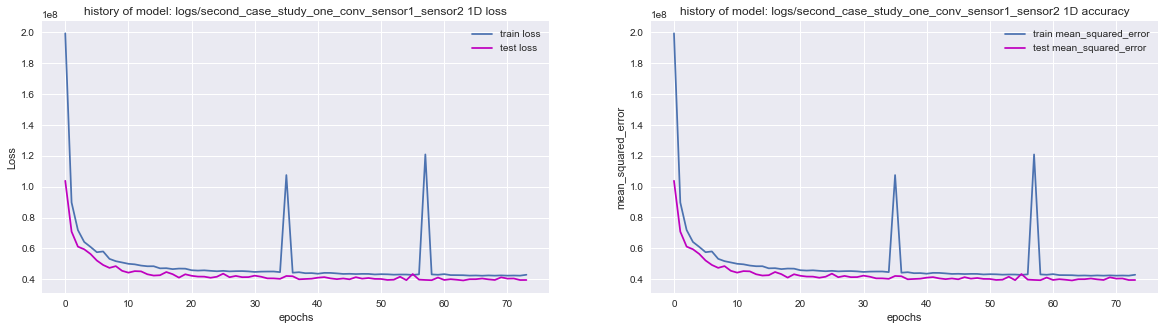

In [28]:
plt.figure(1,figsize=(20,5))
plt.subplot(1,2,1)
plt.title("history of model: {} 1D".format(model_name_to_load)+ " loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
try:
    plt.plot(his['X_loss'][20:], label = 'X train loss')
    plt.plot(his['val_X_loss'][20:], label = 'X test loss')
    plt.plot(his['Y_loss'][20:], label = 'Y train loss')
    plt.plot(his['val_Y_loss'][20:], label = 'Y test loss')
    plt.plot(his['Z_loss'][20:], label = 'Z train loss')
    plt.plot(his['val_Z_loss'][20:], label = 'Z test loss')
except:
    plt.plot(his['loss'], label = 'train loss')
    plt.plot(his['val_loss'], label = 'test loss',color='m')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.title("history of model: {} 1D".format(model_name_to_load)+ " accuracy")
plt.xlabel("epochs")
plt.ylabel('mean_squared_error')
try:
    plt.plot(his['X_mean_squared_error'][20:], label = 'X train mean_squared_error')
    plt.plot(his['val_X_mean_squared_error'][20:], label = 'X test mean_squared_error' )
    plt.plot(his['Y_mean_squared_error'][20:], label = 'Y train mean_squared_error')
    plt.plot(his['val_Y_mean_squared_error'][20:], label = 'Y test mean_squared_error' )
    plt.plot(his['Z_mean_squared_error'][20:], label = 'Z train mean_squared_error')
    plt.plot(his['val_Z_mean_squared_error'][20:], label = 'Z test mean_squared_error' )
except:
    plt.plot(his['mean_squared_error'], label = 'train mean_squared_error')
    plt.plot(his['val_mean_squared_error'], label = 'test mean_squared_error',color='m')
plt.grid(True)
plt.legend()
plt.savefig('{}/graph.png'.format(model_name_to_save))

# test

## normal

In [98]:
import math
import statistics

c,c2,index=0,0,0
errors={}
validation={}
poly_space=[]

Xconstant=0
Zconstant=0 
Yconstant=0
 
    
    
for i in model.predict(X_test):
    x,y=i
    x2,y2=y_test.to_numpy()[c2]
    validation[c]=[x,y,index,'predict']
    c+=1
    errors[c]=math.sqrt((1/2)*((x2-x)**2+(y2-y)**2))
    validation[c]=[x2,y2,index,'actual']
    poly_space.append(math.sqrt((x2-Xconstant)**2+(y2-Yconstant)**2))
    c+=1
    c2+=1
    index+=1

validation=pd.DataFrame.from_dict(validation, orient='index',columns=['x','y','index','kind'])
validation.to_csv("{}/prediction_per_actual.csv".format(model_name_to_save),index=False)

63/63 [==============================] - 0s 6ms/step


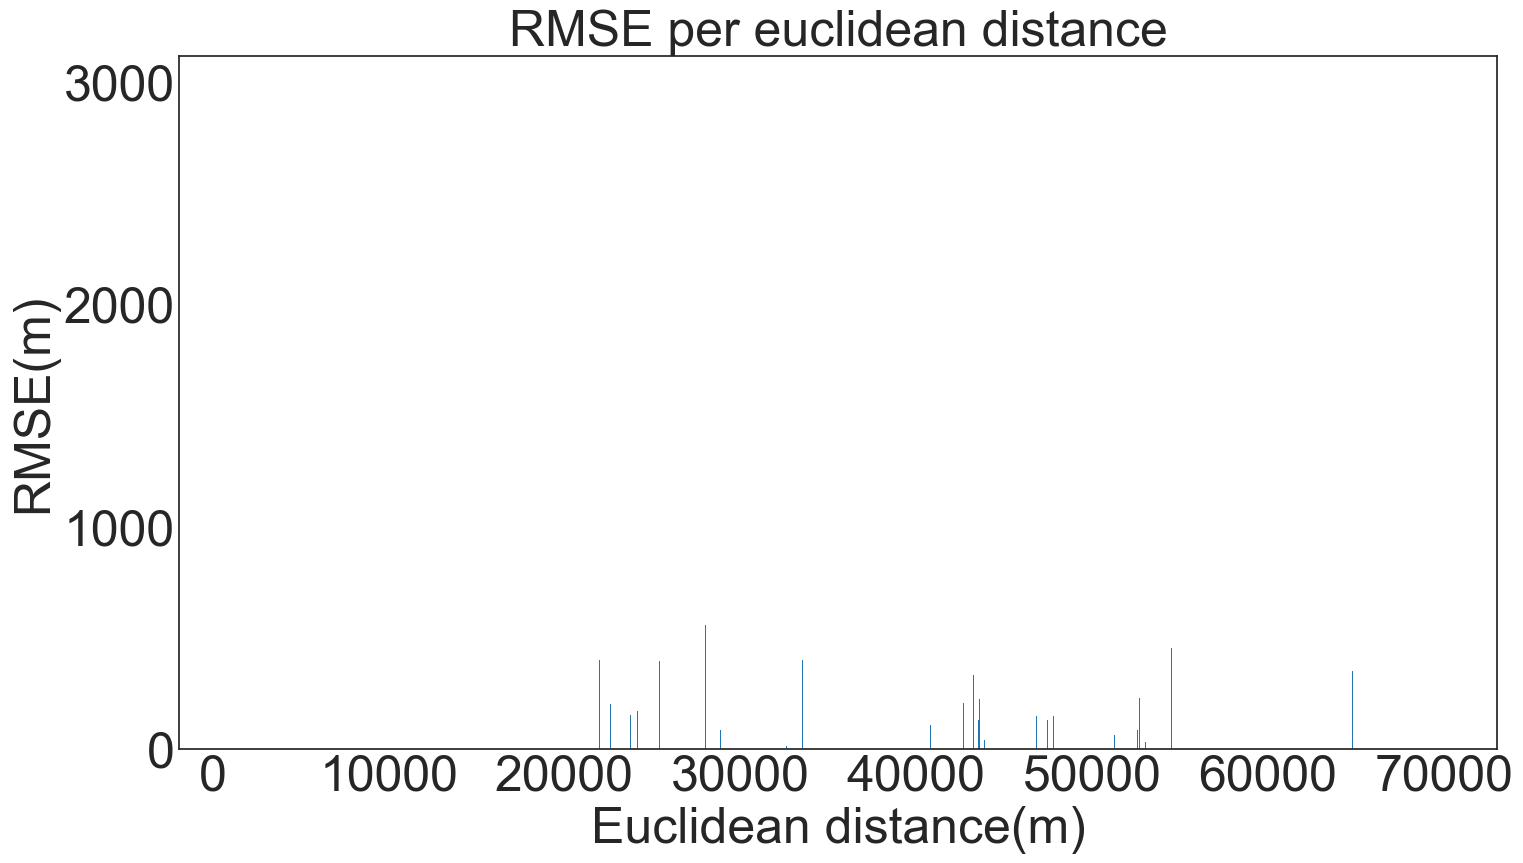

In [94]:
plt.rc('xtick', labelsize=36) 
plt.rc('ytick', labelsize=36) 
plt.figure(1,figsize=(17,9))
plt.title("RMSE per euclidean distance",fontsize=36)

plt.bar(poly_space,list(errors.values()))
plt.ylabel("RMSE(m)",fontsize=36)
plt.xlabel("Euclidean distance(m)",fontsize=36)

plt.savefig('{}/Euclidean_distance.png'.format(model_name_to_save),dpi=300)

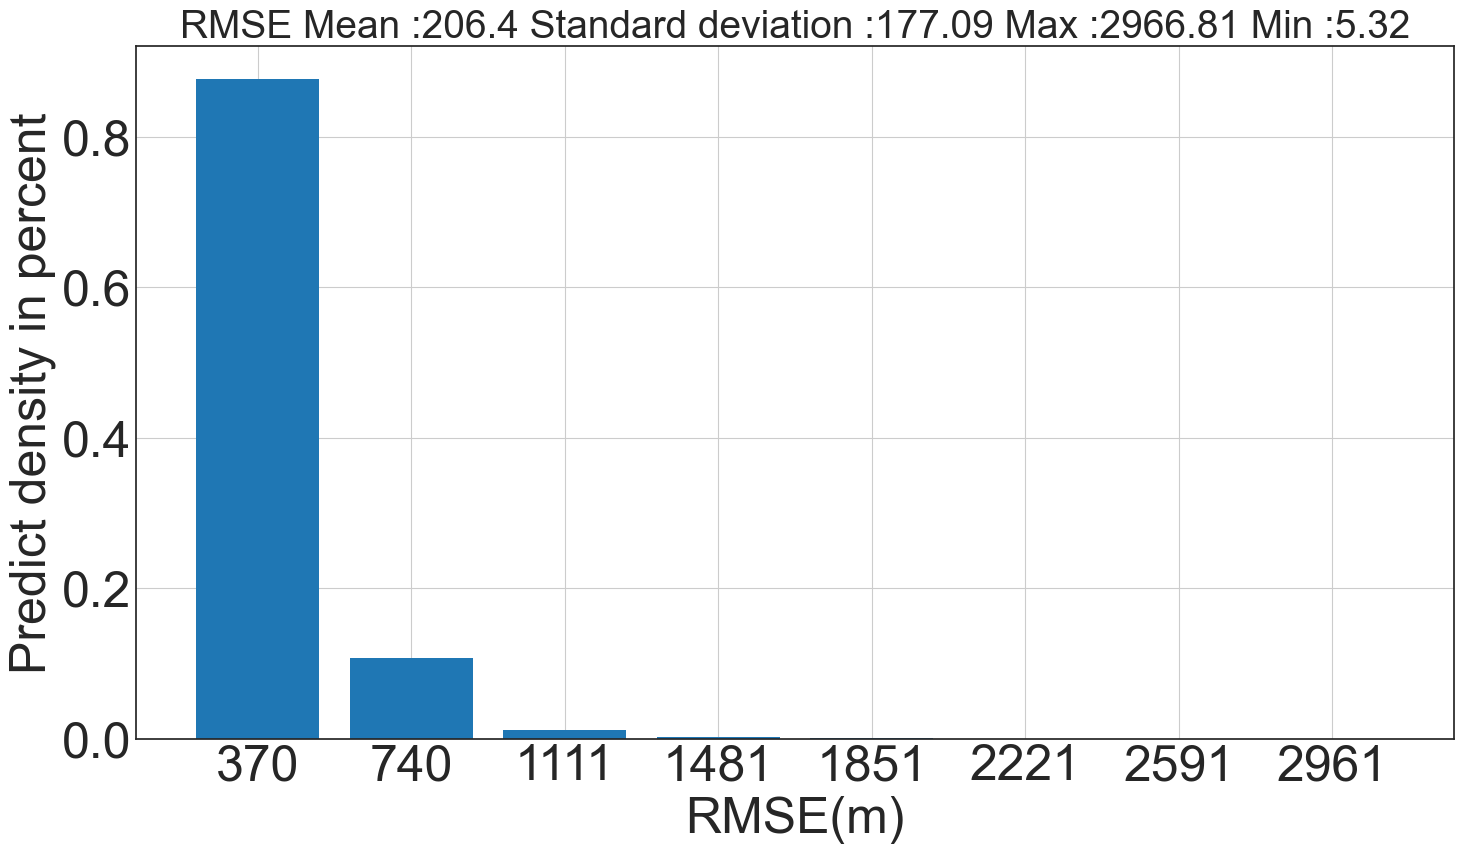

In [93]:
plt.figure(1,figsize=(17,9))
values=list(errors.values())
m=round(np.mean(values),2)
sd=round(statistics.stdev(values),2)
maximum=round(np.max(values),2)
minimum=round(np.min(values),2)

classes=8
step=(maximum-minimum)/classes
a,row=0,0
l,clasifynumbers,groups=[],{},{}
for i in range(classes):
    l.append([a,round(a+step)])
    a=step+a
    clasifynumbers[row]=[]
    row+=1
for i in list(errors.values()):
    row=0
    for j in l:
        if (i>=j[0] and i<=j[1]):
            clasifynumbers[row].append(i)
            break
        row+=1
groups['variety']=[]
for i in range(classes):
    l[i]=str(round(l[i][0]+step))
    groups['variety'].append(len(clasifynumbers[i])/len(values)) 
groups['groups']=l
del l,values,clasifynumbers

plt.title("RMSE Mean :{} Standard deviation :{} Max :{} Min :{}".format(m,sd,maximum,minimum),fontsize=28)
#plt.hist(values, density=True)
plt.bar(groups['groups'],groups['variety'])
plt.grid()
plt.ylabel("Predict density in percent",fontsize=36)
plt.xlabel("RMSE(m)",fontsize=36)

plt.savefig('{}/losses.png'.format(model_name_to_save),dpi=300)

In [307]:
validation[0:10]

,x,y,index,kind
0,26011.001953,32951.320312,0,predict
1,38699.296001,32696.021064,0,actual
2,24828.093750,34665.820312,1,predict
3,31094.150316,34953.502486,1,actual
4,17554.662109,9182.759766,2,predict
5,17776.248775,8941.433559,2,actual
6,13886.942383,16844.923828,3,predict
7,14097.346882,16912.575665,3,actual
8,47984.437500,2471.072998,4,predict
9,49053.192715,3348.198286,4,actual


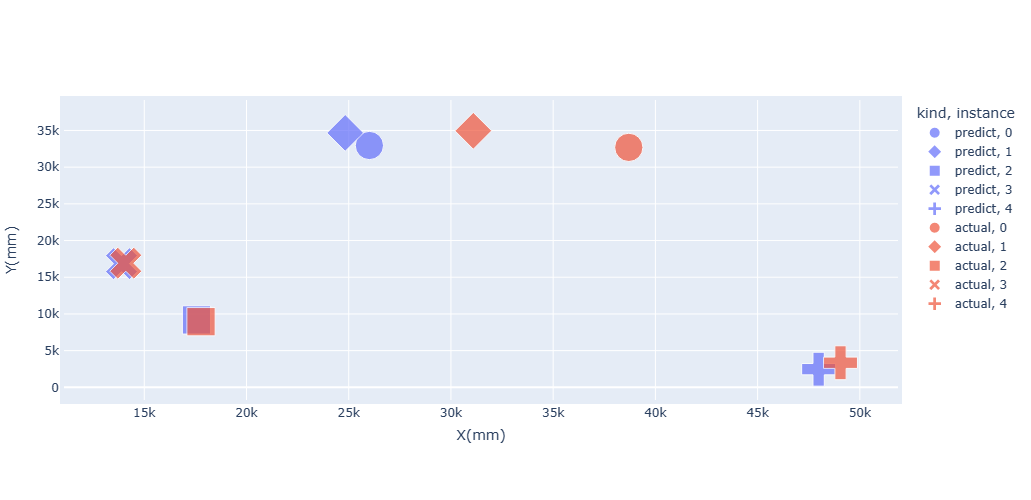

In [308]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px


fig=px.scatter(data_frame = validation[0:10]
            ,x = 'x'
            ,y = 'y'
            ,color = 'kind'
            ,symbol="index"  
            ,size=[10,10,10,10,10,10,10,10,10,10] 
            ,labels={
                     "x": "X(mm)",
                     "y": "Y(mm)",
                     "kind": "kind",
                     "index":"instance"
                 },
           )
fig.update_layout(
    autosize=True,
    width=500,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="white",
)

fig.show()
fig.write_image("{}/YX.png".format(model_name_to_save))

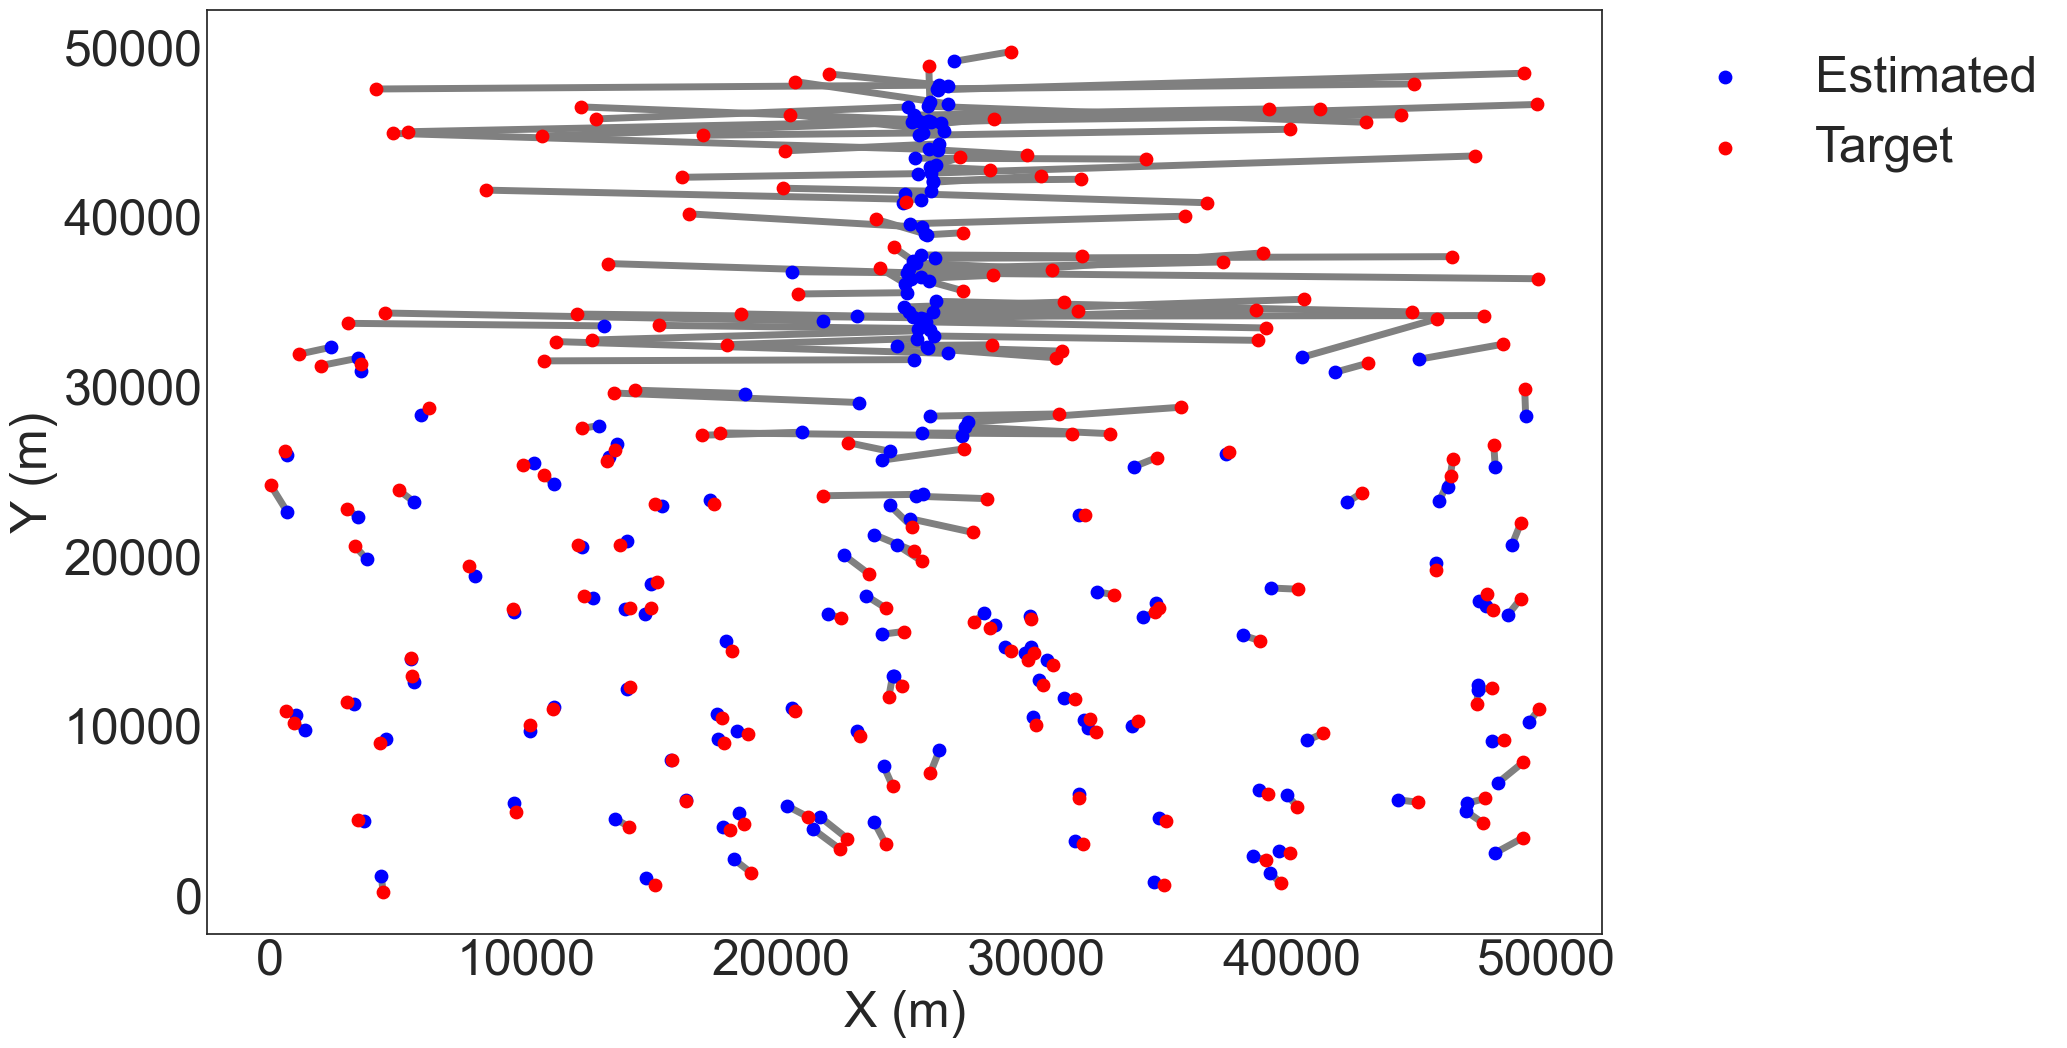

In [309]:
plt.figure(1,figsize=(18,12))
instances=200
x_pred_real=np.concatenate((validation[validation['kind'] == 'predict']['x'].head(instances).to_numpy().reshape(1,-1),
               validation[validation['kind'] == 'actual']['x'].head(instances).to_numpy().reshape(1,-1)),axis=0)
y_pred_real=np.concatenate((validation[validation['kind'] == 'predict']['y'].head(instances).to_numpy().reshape(1,-1),
               validation[validation['kind'] == 'actual']['y'].head(instances).to_numpy().reshape(1,-1)),axis=0)

plt.plot(x_pred_real,y_pred_real,'grey',linewidth=5,zorder=-1)
plt.scatter(validation[validation['kind'] == 'predict']['x'].head(instances),validation[validation['kind'] == 'predict']['y'].head(instances),c='b',s=80, label = "Estimated")
plt.scatter(validation[validation['kind'] == 'actual']['x'].head(instances),validation[validation['kind'] == 'actual']['y'].head(instances),c='r',s=80,label= "Target")
plt.xlabel("X (m)",fontsize=36)
plt.ylabel("Y (m)",fontsize=36)
plt.legend(prop = {'size' : 36},bbox_to_anchor= (1.02, 1))
plt.savefig('{}/2D.png'.format(model_name_to_save),bbox_inches='tight',dpi=500)

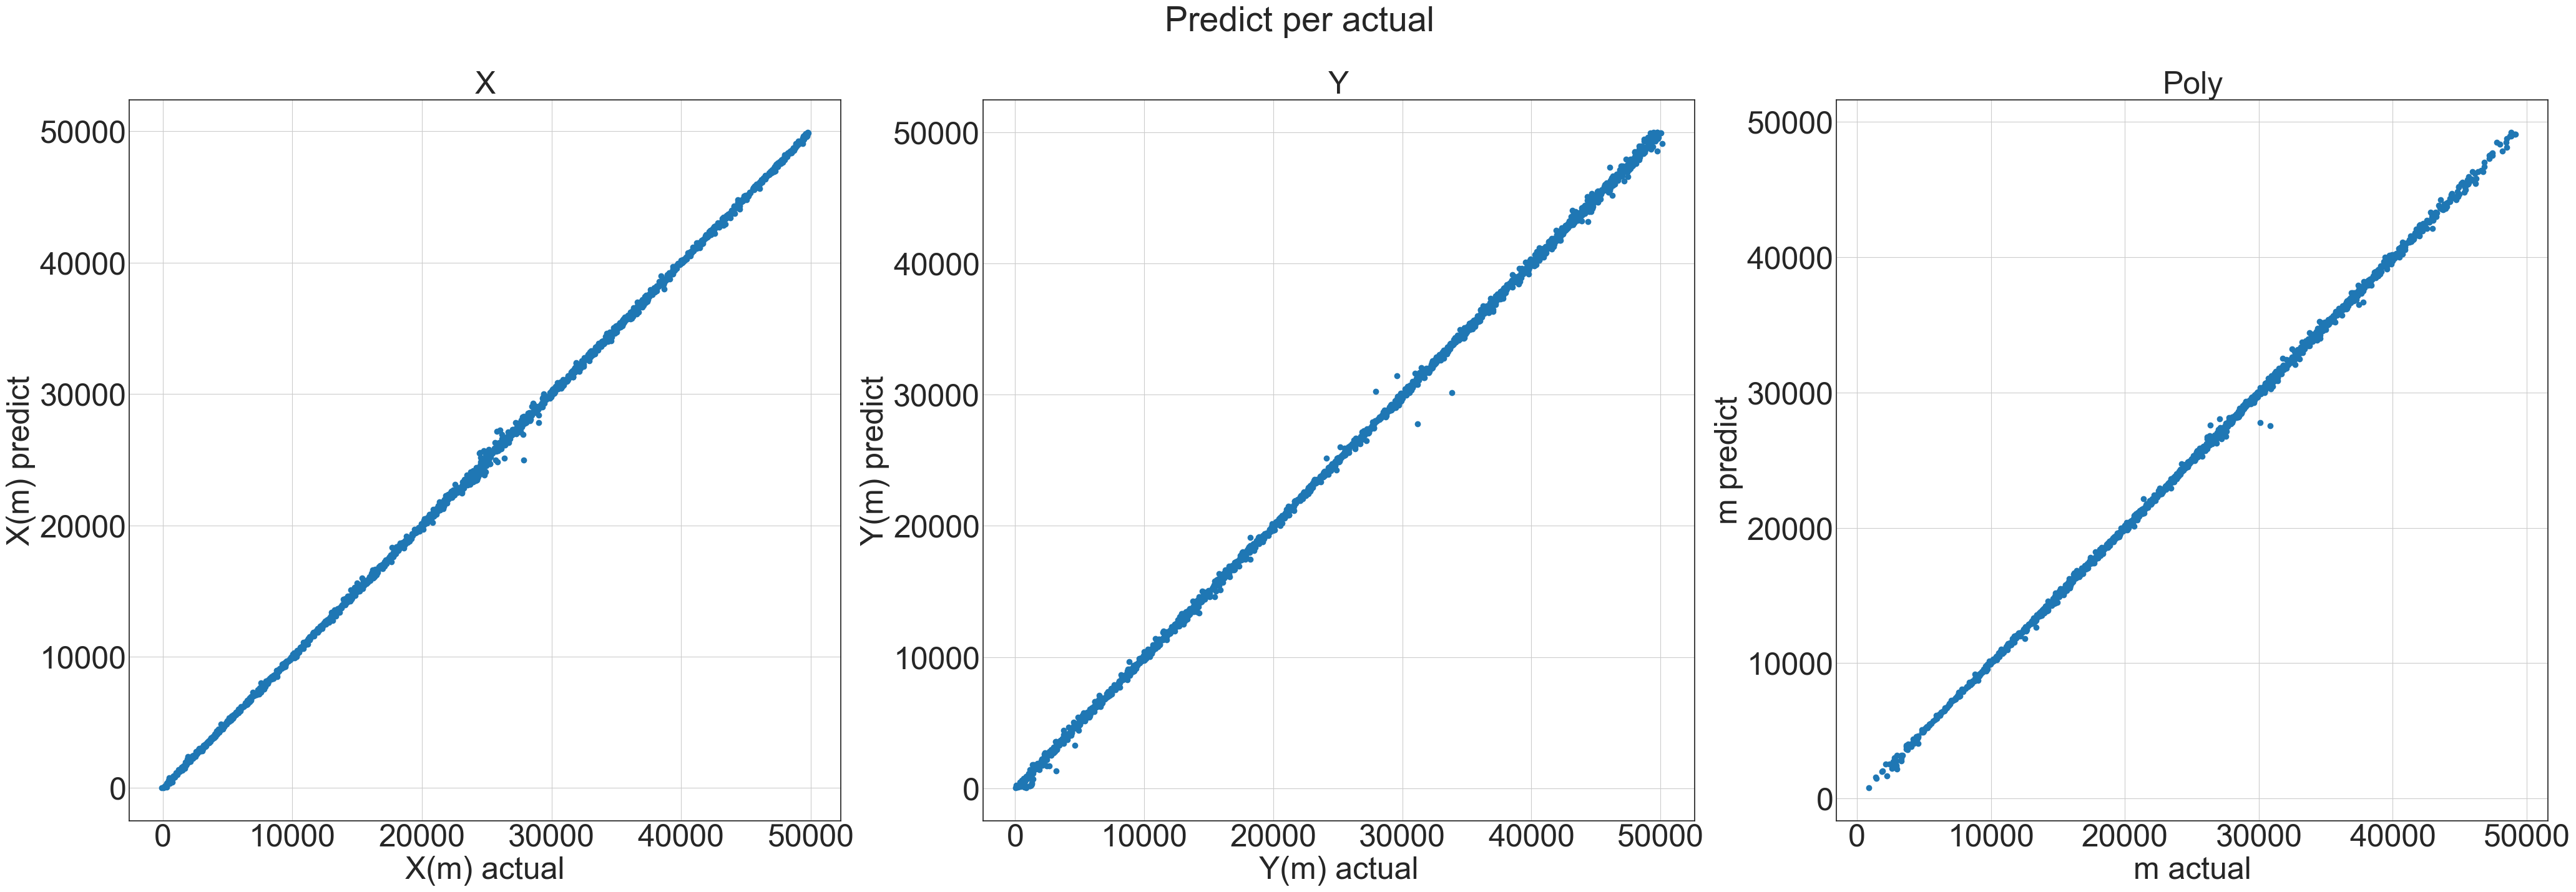

In [99]:
import matplotlib.pyplot as plt
plt.figure(1,figsize=(50,15))
plt.suptitle( 'Predict per actual', fontsize=40)

plt.subplot(1,3,1)
plt.title('X',fontsize=36)
plt.ylabel("X(m) predict",fontsize=36)
plt.xlabel("X(m) actual",fontsize=36)
plt.scatter(validation[validation['kind'] == 'predict']['x'] , validation[validation['kind'] == 'actual']['x'])

Xconstant=0

plt.plot(range(0,Xconstant),range(0,Xconstant),"r")
plt.grid(True)

plt.subplot(1,3,2)
plt.title('Y',fontsize=36)
plt.ylabel("Y(m) predict",fontsize=36)
plt.xlabel("Y(m) actual",fontsize=36)
plt.scatter(validation[validation['kind'] == 'predict']['y'] , validation[validation['kind'] == 'actual']['y'])
    
Yconstant=0

plt.plot(range(0,Yconstant),range(0,Yconstant),"r")
plt.grid(True)

plt.subplot(1,3,3)
plt.title('Poly',fontsize=36)
plt.ylabel("m predict",fontsize=36)
plt.xlabel("m actual",fontsize=36)
plt.scatter((validation[validation['kind'] == 'predict']['x']+validation[validation['kind'] == 'predict']['y'])/2, (validation[validation['kind'] == 'actual']['x']+validation[validation['kind'] == 'actual']['y'])/2)


plt.plot(range(0,int((Xconstant+Yconstant)/2)),range(0,int((Xconstant+Yconstant)/2)),"r")
plt.grid(True)

plt.savefig('{}/evaluate.png'.format(model_name_to_save))

## correlation coefficient r

In [284]:
from sklearn.metrics import mean_squared_error
RMSE_X=np.sqrt(mean_squared_error(validation[validation['kind'] == 'actual']['x'],validation[validation['kind'] == 'predict']['x']))
RMSE_Y=np.sqrt(mean_squared_error(validation[validation['kind'] == 'actual']['y'],validation[validation['kind'] == 'predict']['y']))
with open('{}/evaluate.txt'.format(model_name_to_save),'a') as f:
    rx=np.corrcoef(validation[validation['kind'] == 'predict']['x'],validation[validation['kind'] == 'actual']['x'])[0][1]
    print('X=',rx)
    f.write('\nX={}\n'.format(rx))
    ry=np.corrcoef(validation[validation['kind'] == 'predict']['y'],validation[validation['kind'] == 'actual']['y'])[0][1]
    print('Y=',ry)
    f.write('Y={}\n'.format(ry))
    print('RMSE X=',RMSE_X)
    print('RMSE Y=',RMSE_Y)
    f.write('\nRMSE X={}\n'.format(RMSE_X))
    f.write('RMSE Y={}\n'.format(RMSE_Y))

X= 0.9495953190727201
Y= 0.9522696914233336
RMSE X= 4485.149203839152
RMSE Y= 4501.099567802726


# Noise resistance

In [311]:
import os
import math

samplerate=2000
#noisescales=[0.1,0.2,0.3,0.4,0.5,0.6,0.7] 
noisescales=[5,10,20,30,40] #Set target SNR
X,Y=[],[]
Xm,Ym=[],[]
RMSE=[]
progressbar = display(progress(0, len(noisescales)), display_id=True)   
for c3,noisescale in enumerate(noisescales):  
    #noise = np.random.normal(0, noisescale, x_test.shape)
    # x_valid = np.add(x_test,noise)     
    # del noise
    x_valid=[]
    for signal in x_test: 
        signal_watts=signal ** 2
        signal_db = 10 * np.log10(signal_watts)
        signal_watts_avg_watts = np.mean(signal_watts)
        signal_avg_db = 10 * np.log10(signal_watts_avg_watts)
        noise_avg_db = signal_avg_db - noisescale
        noise_avg_watts = 10 ** (noise_avg_db / 10)
        # Generate an sample of white noise
        noise_volts = np.random.normal(0, np.sqrt(noise_avg_watts), len(signal))
        # Noise up the original signal
        signal = np.add(signal,noise_volts)
        x_valid.append(signal)
    x_valid=np.array(x_valid)
    x_valid = x_valid.reshape(len(x_valid), x_valid.shape[1],1)
    
    errors={}
    predicted=model.predict(x_valid)
    errors['X']=np.sqrt(mean_squared_error(y_test['X'],predicted[:,0]))
    errors['Y']=np.sqrt(mean_squared_error(y_test['Y'],predicted[:,1]))

    # Evaluate the model on the validate data using `evaluate`
    print("Evaluate on noisy data")
    results = model.evaluate(x_valid, y_test, batch_size=10)
    print("\n",80*"=")
    X.append(np.corrcoef(predicted[:,0],y_test['X'])[0][1])
    Y.append(np.corrcoef(predicted[:,1],y_test['Y'])[0][1])
    Xm.append(errors['X'])
    Ym.append(errors['Y'])
    RMSE.append(np.sqrt(results[0]))
    progressbar.update(progress(c3+1, len(noisescales)))
    
Audio('alarm.mp3',autoplay=True)    

C:\Users\farzi\AppData\Local\Temp\ipykernel_1604\3799576019.py:18: RuntimeWarning:

divide by zero encountered in log10



63/63 [==============================] - 0s 4ms/step
Evaluate on noisy data
200/200 [==============================] - 0s 2ms/step - loss: 98111216.0000 - mean_squared_error: 98111216.0000



C:\Users\farzi\AppData\Local\Temp\ipykernel_1604\3799576019.py:18: RuntimeWarning:

divide by zero encountered in log10



63/63 [==============================] - 0s 2ms/step
Evaluate on noisy data
200/200 [==============================] - 0s 2ms/step - loss: 55188300.0000 - mean_squared_error: 55188300.0000



C:\Users\farzi\AppData\Local\Temp\ipykernel_1604\3799576019.py:18: RuntimeWarning:

divide by zero encountered in log10



63/63 [==============================] - 0s 3ms/step
Evaluate on noisy data
200/200 [==============================] - 0s 2ms/step - loss: 38321324.0000 - mean_squared_error: 38321324.0000



C:\Users\farzi\AppData\Local\Temp\ipykernel_1604\3799576019.py:18: RuntimeWarning:

divide by zero encountered in log10



63/63 [==============================] - 0s 4ms/step
Evaluate on noisy data
200/200 [==============================] - 1s 3ms/step - loss: 36289808.0000 - mean_squared_error: 36289808.0000



C:\Users\farzi\AppData\Local\Temp\ipykernel_1604\3799576019.py:18: RuntimeWarning:

divide by zero encountered in log10



63/63 [==============================] - 0s 3ms/step
Evaluate on noisy data
200/200 [==============================] - 1s 3ms/step - loss: 36238220.0000 - mean_squared_error: 36238220.0000



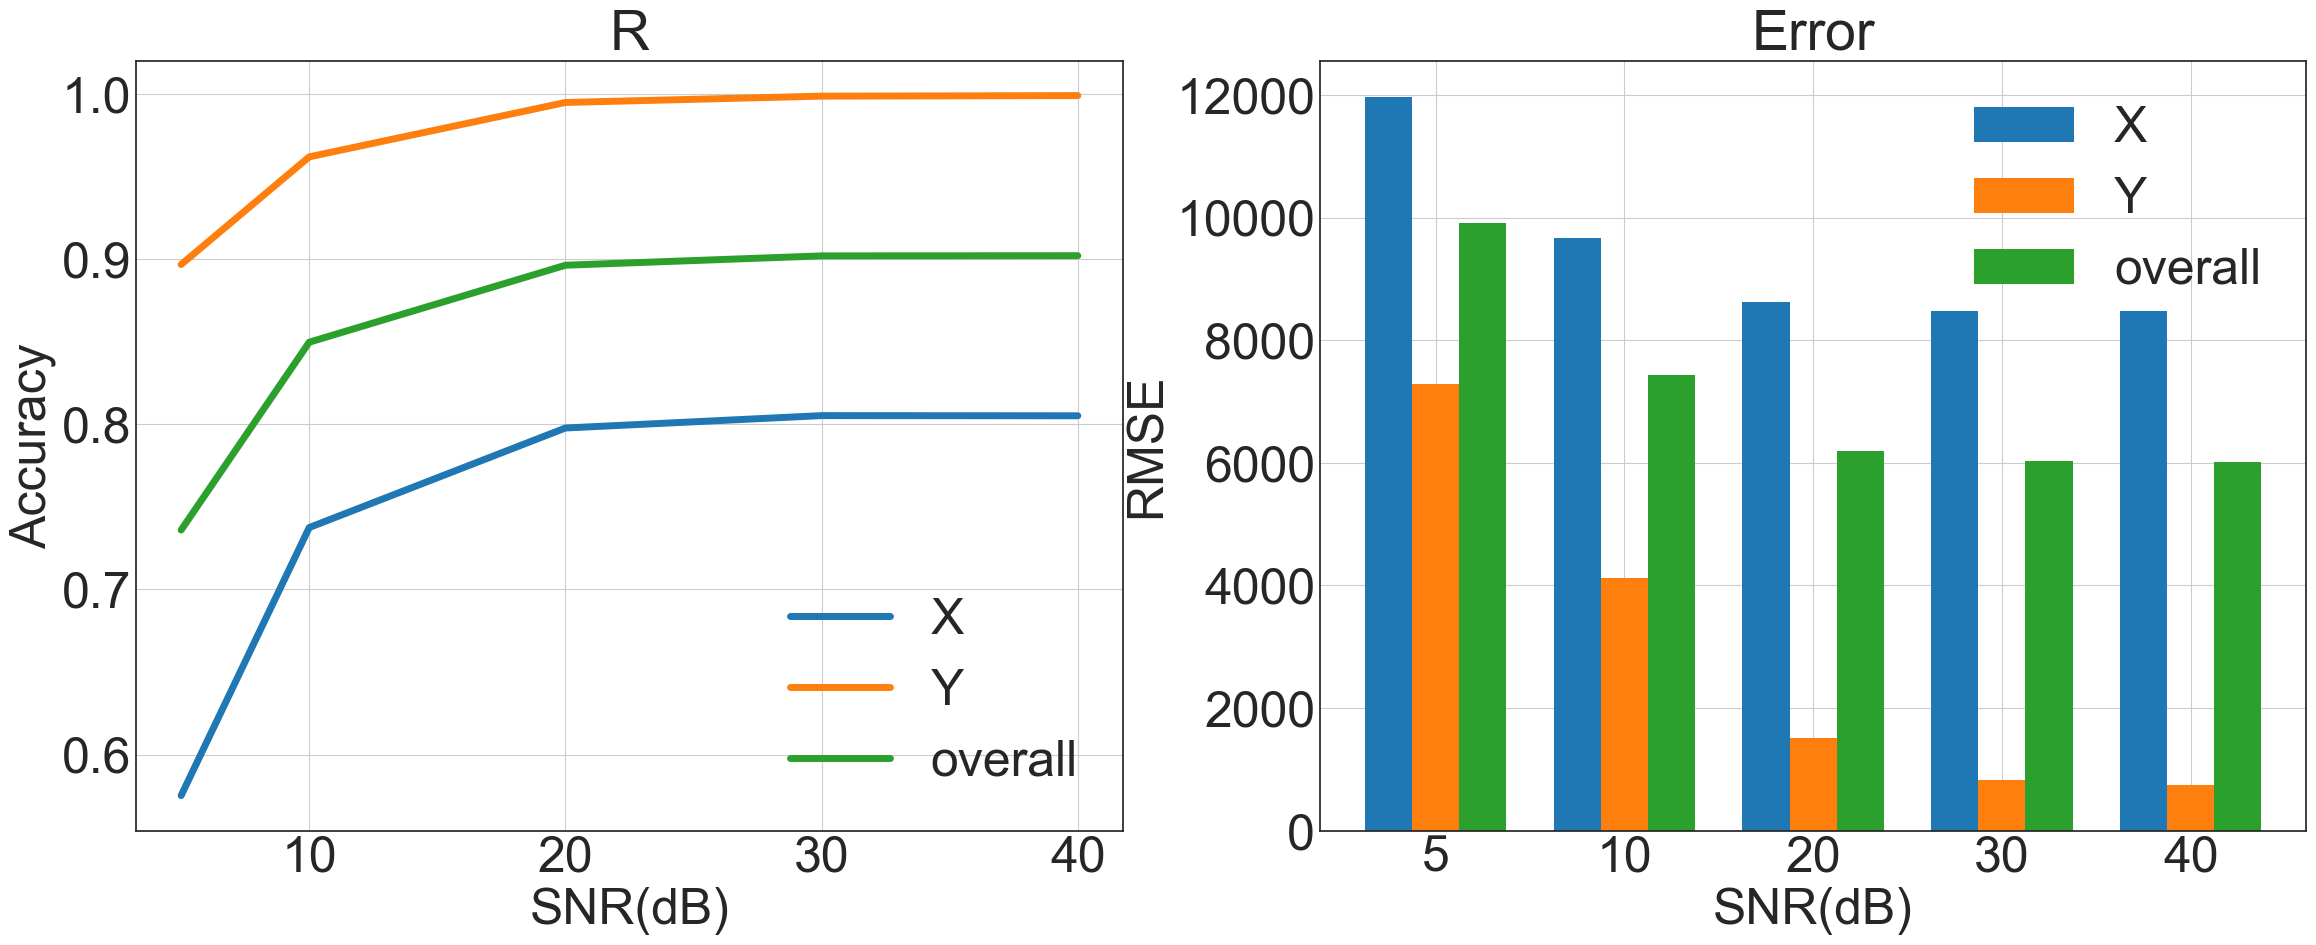

In [312]:
plt.style.use('seaborn-white')
plt.figure(figsize = (28, 10))
plt.subplot(121)
plt.title("R",fontsize=40)

plt.plot(noisescales,X,label='X',linewidth=5)
plt.plot(noisescales,Y,label='Y',linewidth=5)
plt.plot(noisescales,(np.array(X)+np.array(Y))/2,label='overall',linewidth=5)
plt.grid('True')
plt.legend(prop = {'size' : 36})
plt.xlabel('SNR(dB)',fontsize=36)
plt.ylabel('Accuracy',fontsize=36)

plt.subplot(122)
plt.title("Error",fontsize=40)
barWidth=0.25
br1 = np.arange(len(noisescales))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
plt.bar(br1,Xm,label='X',width = barWidth)
plt.bar(br2,Ym,label='Y',width = barWidth)
plt.bar(br3,RMSE,label='overall',width = barWidth)
plt.grid('True')
plt.legend(prop = {'size' : 36})
plt.xlabel('SNR(dB)',fontsize=36)
plt.ylabel('RMSE',fontsize=36)
plt.xticks([r + barWidth for r in range(len(noisescales))],noisescales)
plt.savefig('{}/noise.png'.format(model_name_to_save))

# Sensors location study

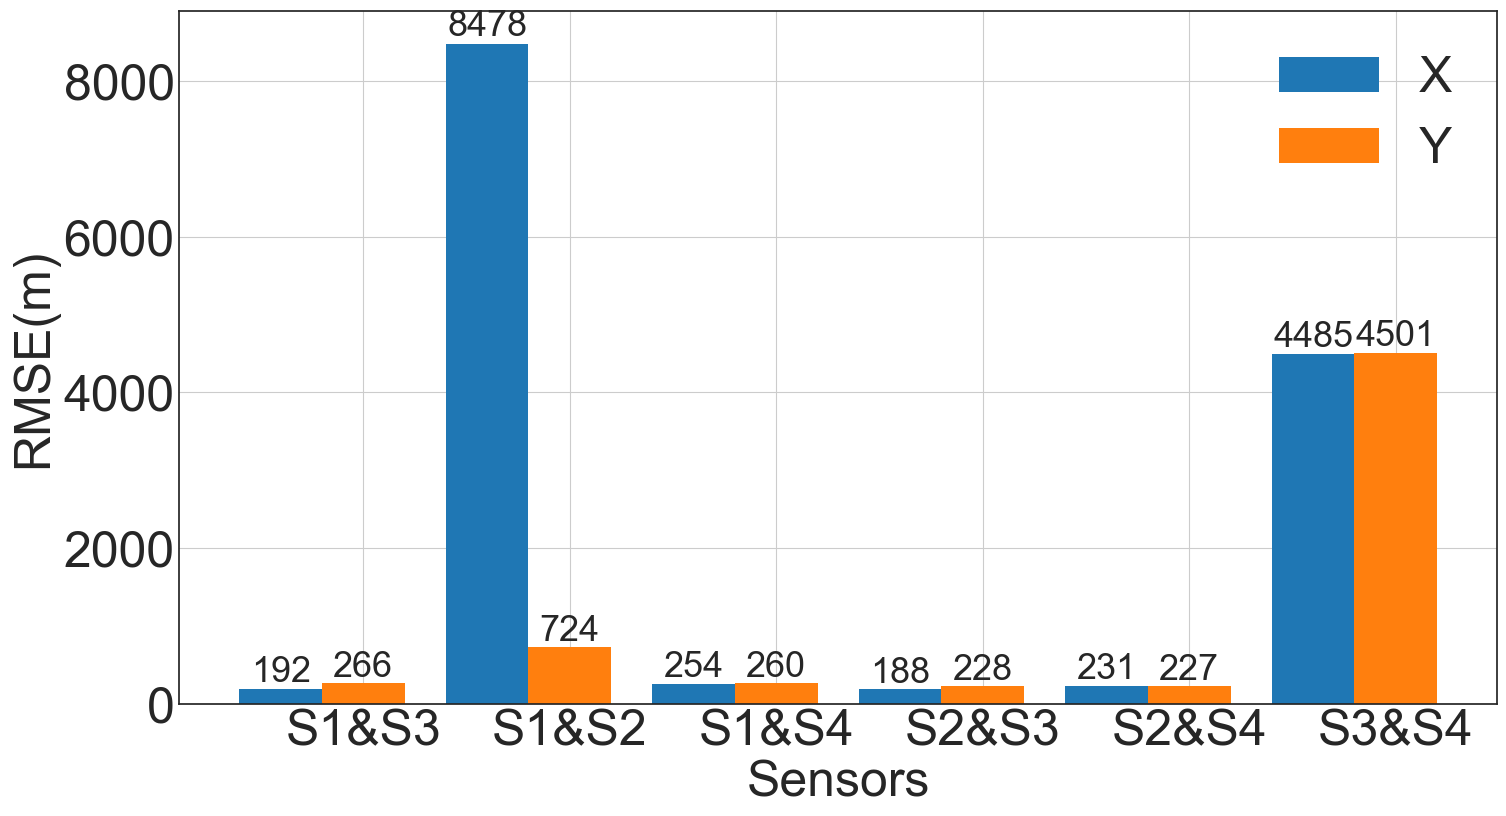

In [166]:
plt.figure(1,figsize=(17,9))
data={'match':[],'RMSE X':[],'RMSE Y':[]}
for i in os.listdir('logs'):
    if i[-1]=='1':
        f=open(Path("logs/{}/evaluate.txt".format(i)),'r')
        lines=f.readlines()
        #loss=float(f.readlines()[1].rstrip()[len('Test loss:'):])
        x_loss=float(lines[-2].rstrip()[len('RMSE X='):])
        y_loss=float(lines[-1].rstrip()[len('RMSE Y='):])
        i=i[len('sensorlocation_case_study_sensor'):-len('_config1')]
        i='S'+i[0]+'&'+'S'+i[-1]
        # if i=="S1&S2" or i=="S3&S4":
        #     continue
        data['match'].append(i)
        data['RMSE X'].append(x_loss)
        data['RMSE Y'].append(y_loss)
        
barWidth=0.4
plt.title("")
br1 = np.arange(len(data['match']))
br2 = [x + barWidth for x in br1]
plot=plt.bar(br1,data['RMSE X'],label='X',width = barWidth)
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom',fontsize='xx-large')
plot=plt.bar(br2,data['RMSE Y'],label='Y',width = barWidth)
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom',fontsize='xx-large')
plt.grid('True')
plt.legend(prop = {'size' : 36})
plt.ylabel("RMSE(m)",fontsize=36)
plt.xlabel("Sensors",fontsize=36)
plt.xticks([r + barWidth for r in range(len(data['match']))],data['match'])
plt.savefig('logs/sensors.png',dpi=300)